# DCGAN - Deep Convolutional Generative Adversarial Networks - Keras

In this notebook, we will be exploring another variant of GANs' called DCGANs'. In the previous notebook, we implemented a GAN using MLP. However, unfortunately, that model was struck by mode collapse and could not learn much. In this notebook, we will be building a deep convolutional GAN which will hopefully help us overcome that issue.

This notebook is based on the paper : (we dont use exact same architecture though)

Reference : https://arxiv.org/abs/1511.06434

**NOTE**

We will be directly using the helper functions we built in the MLP GAN notebook. So for references to those methods, please consult that notebook.

## Imports

In [37]:
from __future__ import division,print_function
from PIL import Image
import gc,re

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, LeakyReLU, Reshape, Convolution2D, \
                         UpSampling2D, Flatten, Dropout
#from keras.layers.merge import Add
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from importlib import reload
from keras import backend as K
from keras.datasets import imdb

np.random.seed(7)

from keras.preprocessing.image import load_img, img_to_array

import bcolz
from IPython.display import FileLink
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from keras import metrics
from scipy.misc import imsave
import imageio

%matplotlib inline

## Load Dataset

In [38]:
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
limit_mem()

In [39]:
from keras.datasets import mnist

(X_train, y_train), (X_test,y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [40]:
def plot(im,sz):
    fig = plt.figure(figsize=(7,7))
    for i, img in enumerate(im):
        a = fig.add_subplot(sz,sz,i+1)
        plt.imshow(img, cmap='gray')

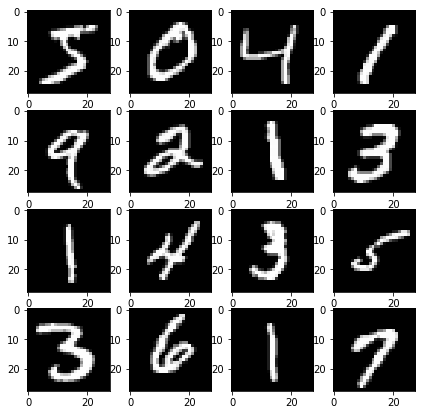

In [41]:
plot(X_train[:16],4)

In [42]:
n = len(X_train)


In [43]:
X_train[0][21]

array([  0,   0,   0,   0,   0,   0,   0,   0,  23,  66, 213, 253, 253, 253, 253, 198,  81,   2,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint8)

Since we will be working with CNNs' we are not flattening the data as we did for MLP GAN. Instead, we add a 1 to the fourth dimension since that is the dimension for color channel in tensorflow.

(1 because we have grayscale images).

Also, we will be using tanh as the activation function in the last layer of our generator. Tanh reduces the weights to [-1,1]. So, we are rescaling our image floats to be in the same range of [-1,1]

In [44]:
X_train = X_train.reshape(n, 28,28,1)
X_test = X_test.reshape(len(X_test), 28,28,1)

X_train = (X_train - 127.5) / 127.5

X_train.shape

(60000, 28, 28, 1)

In [45]:
X_train[0][21]

array([[-1.    ],
       [-1.    ],
       [-1.    ],
       [-1.    ],
       [-1.    ],
       [-1.    ],
       [-1.    ],
       [-1.    ],
       [-0.8196],
       [-0.4824],
       [ 0.6706],
       [ 0.9843],
       [ 0.9843],
       [ 0.9843],
       [ 0.9843],
       [ 0.5529],
       [-0.3647],
       [-0.9843],
       [-1.    ],
       [-1.    ],
       [-1.    ],
       [-1.    ],
       [-1.    ],
       [-1.    ],
       [-1.    ],
       [-1.    ],
       [-1.    ],
       [-1.    ]])

## Helper Functions

In [46]:
g_inp_dim = 100
batch_size = 128
n_epochs = 1000

In [47]:
def get_noise_for_G(n_examples):
    noise = np.random.rand(n_examples, g_inp_dim)
    return noise

In [48]:
def get_data_for_D(n_samples, G):
    X_real = X_train[np.random.randint(0,n,size=n_samples)]
    X_fake = G.predict(get_noise_for_G(n_samples))
    
    X = np.concatenate((X_real, X_fake))
    
    y_real = [0]*n_samples    # 0 is for real
    y_fake = [1]*n_samples    # 1 is for fake
    y = y_real + y_fake
    
    return X,y

In [49]:
def make_trainable(model, val):
    model.trainable = val
    for layer in model.layers:
        layer.trainable = val
    #model.compile(optimizer='adam', loss='binary_crossentropy')

In [50]:
from tqdm import tqdm
def train(D,G,m,epochs=n_epochs, batch_size = 128, n_samples = 64):
    dl, gl = [],[]
    for i in tqdm(range(epochs)):
        
        X,y = get_data_for_D(n_samples, G)
        dl.append(D.train_on_batch(X,y))
        
        # After training the Discriminator, we want to train the Generator. 
        # We dont want to modify the Discriminator while doing that.
        make_trainable(D,False)
        
        X_G = get_noise_for_G(batch_size)
        y_G = [0]*batch_size   # we want the generator to generate images which look real
        gl.append(m.train_on_batch(X_G,y_G))
        
        # After training the Generator, we want to train the Discriminator. 
        make_trainable(D, True)
    return dl,gl

## Create Models

### Create Generator CNN

We reshape into 7x7 because we will be doing two upsampling steps. Each step will double the size of the image and this the final image will be of 28x28.

In the final Convolutional layer, we have number of filters as 1 since we are working with grayscale images.

In [51]:
inpG = Input(shape=(g_inp_dim,), name='Input_G')
x = Dense(512*7*7) (inpG)
x = LeakyReLU(0.2)(x)
x = BatchNormalization()(x)
x = Reshape((7,7,512))(x)
x = UpSampling2D()(x)
x = Convolution2D(filters=64, kernel_size=(5,5), padding='same')(x)
x = LeakyReLU(0.2)(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
#x = Convolution2D(filters=32, kernel_size=(3,3), padding='same')(x)
#x = LeakyReLU()(x)
#x = BatchNormalization()(x)
outG = Convolution2D(filters=1, kernel_size=(1,1), padding='same', activation='tanh')(x)

CNN_G = Model(inputs=inpG, outputs=outG)
CNN_G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_G (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 25088)             2533888   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 25088)             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 25088)             100352    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 512)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        819264    
__________

### Create Discriminator CNN

In [52]:
inpD = Input(shape=(28,28,1), name='Input_D')
x = Convolution2D(filters=256, kernel_size=(5,5), padding='same', strides=(2,2))(inpD)
x = LeakyReLU(0.2)(x)
x = Convolution2D(filters=512, kernel_size=(5,5), padding='same', strides=(2,2))(x)
x = LeakyReLU(0.2)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = LeakyReLU()(x)
outD = Dense(1, activation='sigmoid')(x)

CNN_D = Model(inputs=inpD, outputs=outD)
CNN_D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_D (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 256)       6656      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 512)         3277312   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               6422784   
__________

In [53]:
CNN_D.compile(optimizer=Adam(), loss='binary_crossentropy')

### DCGAN : Combined Generator and Discriminator 

Now the final model is when we feed an input to the generator, get its output which is then fed to the discriminator. 

**DCGAN = CNN_D ( CNN_G ( input) ) **


In [54]:
dcgan_input = Input(shape=(g_inp_dim,))
x = CNN_G(dcgan_input)
dcgan_output = CNN_D(x)

dcgan_model = Model(inputs=dcgan_input, outputs=dcgan_output)
dcgan_model.summary()
dcgan_model.compile(optimizer=Adam(), loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_4 (Model)              (None, 28, 28, 1)         3453825   
_________________________________________________________________
model_5 (Model)              (None, 1)                 9707009   
Total params: 13,160,834
Trainable params: 13,110,530
Non-trainable params: 50,304
_________________________________________________________________


In this case, we will initially be training the discriminator on a few batches so that it can learn to identify real images from fake ones.

In [55]:
X_sub, y_sub = get_data_for_D(n_samples=n//200, G=CNN_G)

In [56]:
CNN_D.fit(X_sub, y_sub, batch_size=batch_size, epochs=1, verbose = 2)

Epoch 1/1
 - 1s - loss: 0.3610


In [57]:
dl,gl = train(CNN_D,CNN_G, dcgan_model, epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]/home/kshitijg1992/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 200/200 [01:01<00:00,  3.33it/s]


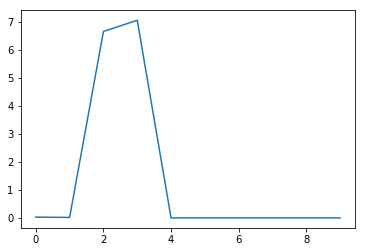

In [58]:
plt.plot(dl[:10])

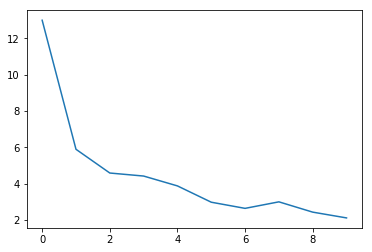

In [59]:
plt.plot(gl[:10])

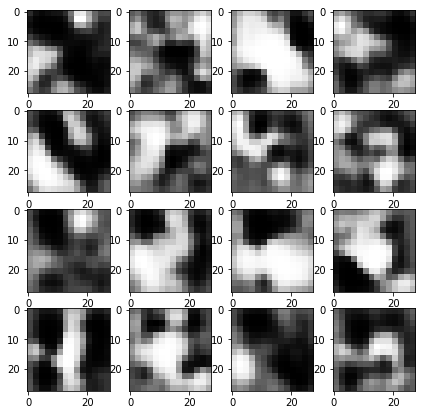

In [60]:
plot(CNN_G.predict(get_noise_for_G(16)).reshape(16, 28,28),4)